In [1]:
import tensorflow as tf
import numpy as np
import cv2

In [14]:
# 8.1 텐서플로 허브에서 사전 훈련된 MobileNet 모델 불러오기
import tensorflow_hub as hub

mobile_net_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
model = tf.keras.Sequential([
    hub.KerasLayer(handle=mobile_net_url, input_shape=(224, 224, 3), trainable=False)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              3540265   
                                                                 
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


In [15]:
# 그림 8.2 좌측 전체 네트워크 구조 출력 코드
from tensorflow.keras.applications import MobileNetV2

mobilev2 = MobileNetV2()
tf.keras.utils.plot_model(mobilev2)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [16]:
# 8.2 ImageNetV2-TopImages 불러오기
import os
import pathlib
from glob import glob
content_data_url = './content/sample_data'
data_root_orig = tf.keras.utils.get_file('imagenetV2', 'https://s3-us-west-2.amazonaws.com/imagenetv2public/imagenetv2-top-images.tar.gz', cache_dir=content_data_url, extract=True)
data_root = pathlib.Path(glob("./content/sample_data/datasets/*/")[0])
print(data_root)

content/sample_data/datasets/imagenetv2-top-images-format-val


In [17]:
# 8.3 디렉토리 출력
for idx, item in enumerate(data_root.iterdir()):
    print(item)
    if idx == 9:
        break

content/sample_data/datasets/imagenetv2-top-images-format-val/797
content/sample_data/datasets/imagenetv2-top-images-format-val/909
content/sample_data/datasets/imagenetv2-top-images-format-val/135
content/sample_data/datasets/imagenetv2-top-images-format-val/307
content/sample_data/datasets/imagenetv2-top-images-format-val/763
content/sample_data/datasets/imagenetv2-top-images-format-val/551
content/sample_data/datasets/imagenetv2-top-images-format-val/61
content/sample_data/datasets/imagenetv2-top-images-format-val/95
content/sample_data/datasets/imagenetv2-top-images-format-val/338
content/sample_data/datasets/imagenetv2-top-images-format-val/936


In [18]:
# 8.4 ImageNet 라벨 텍스트 불러오기
label_file = tf.keras.utils.get_file('label', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
label_text = None
with open(label_file, 'r') as f:
    label_text = f.read().split('\n')[:-1]
print(len(label_text))
print(label_text[:10])
print(label_text[-10:])

# 폴더 이름이 wordnet의 단어로 수정되었기 때문에, nltk 패키지에서 wordnet을 다운받습니다.
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

# wordnet과 인터넷에 올라온 label 텍스트는 조금씩 다르기 때문에 차이를 없애기 위해서 아래의 전처리 작업을 진행합니다.
label_text = [c.lower().replace('-','').replace('_','').replace(' ','') for c in label_text]

1001
['background', 'tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen']
['buckeye', 'coral fungus', 'agaric', 'gyromitra', 'stinkhorn', 'earthstar', 'hen-of-the-woods', 'bolete', 'ear', 'toilet tissue']


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/matalcross_imac/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


image_count: 10000


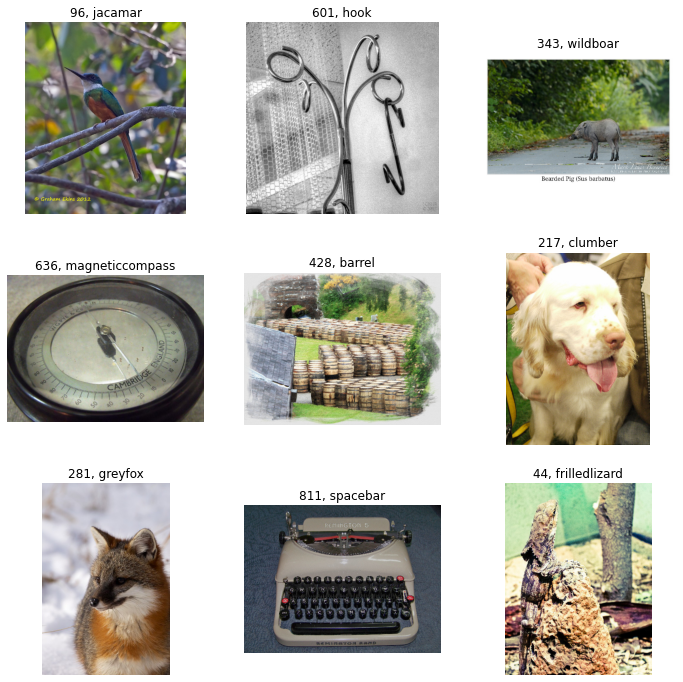

In [20]:
# 8.5 이미지 확인
import PIL.Image as Image
import matplotlib.pyplot as plt
import random

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
# 이미지를 랜덤하게 섞습니다.
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print('image_count:', image_count)

plt.figure(figsize=(12,12))
for c in range(9):
    image_path = random.choice(all_image_paths)
    plt.subplot(3,3,c+1)
    plt.imshow(plt.imread(image_path))
    idx = int(image_path.split('/')[-2]) + 1
    plt.title(str(idx) + ', ' + label_text[idx])
    #
    #word = wordnet.synset_from_pos_and_offset('n',int(image_path.split('/')[-2][1:]))
    #word = word.name().split('.')[0].replace('-','').replace('_','').replace(' ','')
    #plt.title(str(label_text.index(word)) + ', ' + word)
    plt.axis('off')
plt.show()

In [21]:
# 8.6 MobileNet의 분류 성능 확인
import cv2

top_1 = 0
top_5 = 0
for image_path in all_image_paths:
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    top_5_predict = model.predict(img)[0].argsort()[::-1][:5]
    idx = int(image_path.split('/')[-2])+1
    # word = wordnet.synset_from_pos_and_offset('n',int(image_path.split('/')[-2][1:]))
    # word = word.name().split('.')[0].replace('-','').replace('_','').replace(' ','')
    # idx = label_text.index(word)
    if idx in top_5_predict:
        top_5 += 1
        if top_5_predict[0] == idx:
            top_1 += 1

print('Top-5 correctness:', top_5 / len(all_image_paths) * 100, '%')
print('Top-1 correctness:', top_1 / len(all_image_paths) * 100, '%')

2022-03-07 18:20:59.298380: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-07 18:20:59.369925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Top-5 correctness: 83.52000000000001 %
Top-1 correctness: 59.06 %


In [22]:
# numpy.argsort() 설명 코드
a = np.array([99,32,5,64])
arg = np.argsort(a)
print(arg)
print(np.sort(a))
print(a[arg])

[2 1 3 0]
[ 5 32 64 99]
[ 5 32 64 99]


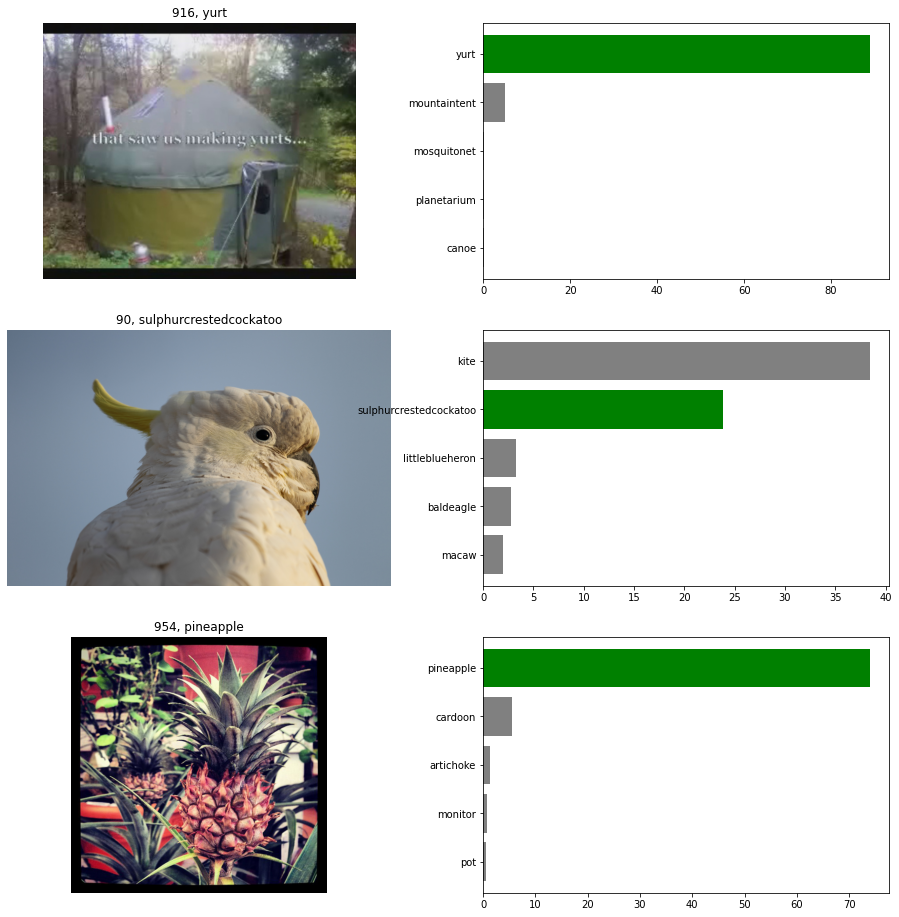

In [23]:
# 8.7 MobileNet의 분류 라벨 확인
plt.figure(figsize=(16,16))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)
  
for c in range(3):
    image_path = random.choice(all_image_paths)
    
    # 이미지 표시
    plt.subplot(3,2,c*2+1)
    plt.imshow(plt.imread(image_path))
    idx = int(image_path.split('/')[-2]) + 1
    plt.title(str(idx) + ', ' + label_text[idx])
    #word = wordnet.synset_from_pos_and_offset('n',int(image_path.split('/')[-2][1:]))
    #word = word.name().split('.')[0].replace('-','').replace('_','').replace(' ','')
    #idx = label_text.index(word)
    #plt.title(str(idx) + ', ' + label_text[idx])
    plt.axis('off')
    
    # 예측값 표시
    plt.subplot(3,2,c*2+2)
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    # MobileNet을 이용한 예측
    logits = model.predict(img)[0]
    prediction = softmax(logits)
    
    # 가장 높은 확률의 예측값 5개를 뽑음
    top_5_predict = prediction.argsort()[::-1][:5]
    labels = [label_text[index] for index in top_5_predict]
    color = ['gray'] * 5
    if idx in top_5_predict:
        color[top_5_predict.tolist().index(idx)] = 'green'
    color = color[::-1]
    plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color=color)
    plt.yticks(range(5), labels[::-1])   

## 8.2.1 모델의 일부를 재학습시키기

In [24]:
# kaggle API를 설치합니다.
!pip install kaggle

In [26]:
# 8.8 Stanford Dog Dataset을 Kaggle에서 불러오기

# 2020.02.01 현재 kaggle의 Stanford Dog Dataset 파일 구조가 변경되었습니다. 
# kaggle API를 사용하는 대신에 아래 링크에서 파일을 직접 받아오도록 수정되었습니다.
tf.keras.utils.get_file('/Users/matalcross_imac/Downloads/ai_exam/content/labels.csv', 'http://bit.ly/2GDxsYS')
tf.keras.utils.get_file('/Users/matalcross_imac/Downloads/ai_exam/content/sample_submission.csv', 'http://bit.ly/2GGnMNd')
tf.keras.utils.get_file('/Users/matalcross_imac/Downloads/ai_exam/content/train.zip', 'http://bit.ly/31nIyel')
tf.keras.utils.get_file('/Users/matalcross_imac/Downloads/ai_exam/content/test.zip', 'http://bit.ly/2GHEsnO')

import os
os.environ['KAGGLE_USERNAME'] = 'matalcross' # 독자의 캐글 ID
os.environ['KAGGLE_KEY'] = '5807a84162d93dc65983d4b7b09fabce' # 독자의 캐글 API Token
# !kaggle competitions download -c dog-breed-identification

Exception: URL fetch failure on http://bit.ly/31nIyel: 500 -- Internal Server Error

In [2]:
# 8.10 labels.csv 파일 내용 확인
import pandas as pd
label_text = pd.read_csv('./content/labels.csv')
print(label_text.head())

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [3]:
# 8.11 labels.csv 정보 확인
label_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [4]:
# 8.12 견종 수 확인
label_text['breed'].nunique()

120

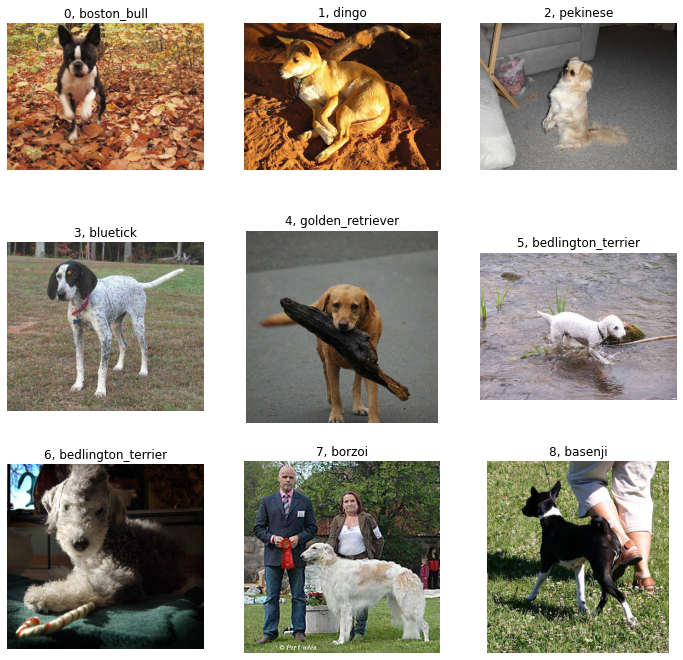

In [30]:
# 8.13 이미지 확인
import PIL.Image as Image
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
for c in range(9):
    image_id = label_text.loc[c, 'id']
    plt.subplot(3,3,c+1)
    plt.imshow(plt.imread('./content/train/' + image_id + '.jpg'))
    plt.title(str(c) + ', ' + label_text.loc[c, 'breed'])
    plt.axis('off')
plt.show()

In [31]:
# 8.14 tf.keras에서 MobileNet V2 불러오기
from tensorflow.keras.applications import MobileNetV2
mobilev2 = MobileNetV2()

In [32]:
# 8.15 MobileNet V2의 가중치 초기화
for layer in mobilev2.layers[:-1]:
    layer.trainable = True
    
for layer in mobilev2.layers[:-1]: 
    if 'kernel' in layer.__dict__:
        kernel_shape = np.array(layer.get_weights()).shape
        # weight를 평균이 0, 표준편차가 1인 random 변수로 초기화
        layer.set_weights(tf.random.normal(kernel_shape, 0, 1))  

In [33]:
# 8.16 train 데이터를 메모리에 로드
import cv2

train_X = []
for i in range(len(label_text)):
    img = cv2.imread('./content/train/' + label_text['id'][i] + '.jpg')
    img = cv2.resize(img, dsize=(224, 224))
    img = img / 255.0
    train_X.append(img)
train_X = np.array(train_X)
print(train_X.shape)
print(train_X.size * train_X.itemsize, ' bytes')

(10222, 224, 224, 3)
12309577728  bytes


In [13]:
# 8.17 train 라벨 데이터를 메모리에 로드
unique_Y = label_text['breed'].unique().tolist()
train_Y = [unique_Y.index(breed) for breed in label_text['breed']]
train_Y = np.array(train_Y)

print(train_Y[:10])
print(train_Y[-10:])

[0 1 2 3 4 5 5 6 7 8]
[34 87 91 63 48  6 93 63 77 92]


In [35]:
# 8.18 Dogs Dataset 학습을 위한 모델 정의
x = mobilev2.layers[-2].output
predictions = tf.keras.layers.Dense(120, activation='softmax')(x)
model = tf.keras.Model(inputs=mobilev2.input, outputs=predictions)

model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [36]:
# 8.19 랜덤한 가중치를 가진 상태에서의 학습
history = model.fit(train_X, train_Y, epochs=10, validation_split=0.25, batch_size=32)

Epoch 1/10


2022-03-07 21:35:28.861792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


240/240 [==============================] - ETA: 0s - loss: 4.8811 - accuracy: 0.0102

2022-03-07 21:37:49.539068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


240/240 [==============================] - 157s 644ms/step - loss: 4.8811 - accuracy: 0.0102 - val_loss: 7.9781 - val_accuracy: 0.0067
Epoch 2/10
240/240 [==============================] - 155s 647ms/step - loss: 4.8554 - accuracy: 0.0085 - val_loss: 8.0545 - val_accuracy: 0.0082
Epoch 3/10
240/240 [==============================] - 155s 646ms/step - loss: 4.8506 - accuracy: 0.0103 - val_loss: 8.0009 - val_accuracy: 0.0082
Epoch 4/10
240/240 [==============================] - 157s 652ms/step - loss: 4.8440 - accuracy: 0.0100 - val_loss: 7.6757 - val_accuracy: 0.0078
Epoch 5/10
240/240 [==============================] - 154s 641ms/step - loss: 4.8436 - accuracy: 0.0124 - val_loss: 7.7459 - val_accuracy: 0.0074
Epoch 6/10
240/240 [==============================] - 154s 641ms/step - loss: 4.8494 - accuracy: 0.0120 - val_loss: 7.8055 - val_accuracy: 0.0047
Epoch 7/10
240/240 [==============================] - 155s 644ms/step - loss: 4.8442 - accuracy: 0.0110 - val_loss: 6.8521 - val_accura

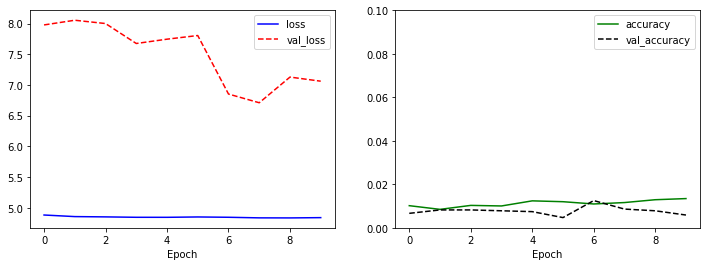

In [37]:
# 8.20 학습 결과 확인
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 0.1)
plt.legend()

plt.show()

In [38]:
# 8.21 Dogs Dataset 학습을 위한 Transfer Learning 모델 정의
from tensorflow.keras.applications import MobileNetV2
mobilev2 = MobileNetV2()

x = mobilev2.layers[-2].output
predictions = tf.keras.layers.Dense(120, activation='softmax')(x)
model = tf.keras.Model(inputs=mobilev2.input, outputs=predictions)

# 뒤에서 20개까지의 레이어는 훈련 가능, 나머지는 가중치 고정
for layer in model.layers[:-20]:
    layer.trainable = False
for layer in model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

Epoch 1/10


2022-03-07 22:02:42.936882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


240/240 [==============================] - ETA: 0s - loss: 4.8120 - accuracy: 0.0108

2022-03-07 22:03:41.325291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


240/240 [==============================] - 73s 301ms/step - loss: 4.8120 - accuracy: 0.0108 - val_loss: 4.8521 - val_accuracy: 0.0262
Epoch 2/10
240/240 [==============================] - 63s 265ms/step - loss: 4.7438 - accuracy: 0.0163 - val_loss: 4.6059 - val_accuracy: 0.0575
Epoch 3/10
240/240 [==============================] - 64s 265ms/step - loss: 4.6886 - accuracy: 0.0334 - val_loss: 4.3462 - val_accuracy: 0.1138
Epoch 4/10
240/240 [==============================] - 65s 270ms/step - loss: 4.6340 - accuracy: 0.0481 - val_loss: 4.0889 - val_accuracy: 0.1475
Epoch 5/10
240/240 [==============================] - 64s 266ms/step - loss: 4.5839 - accuracy: 0.0582 - val_loss: 3.8677 - val_accuracy: 0.1870
Epoch 6/10
240/240 [==============================] - 63s 263ms/step - loss: 4.5441 - accuracy: 0.0691 - val_loss: 3.7053 - val_accuracy: 0.1944
Epoch 7/10
240/240 [==============================] - 66s 274ms/step - loss: 4.5145 - accuracy: 0.0761 - val_loss: 3.6225 - val_accuracy: 0.2

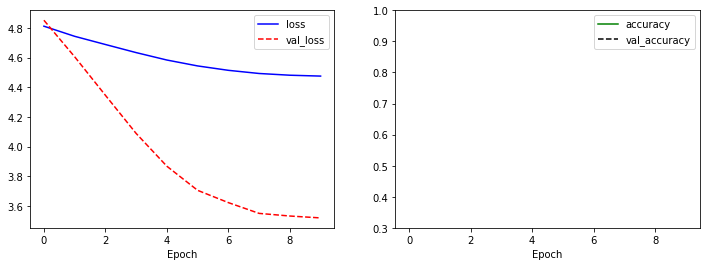

In [39]:
# 8.22 모델 학습 및 결과 확인
history = model.fit(train_X, train_Y, epochs=10, validation_split=0.25, batch_size=32)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.3, 1)
plt.legend()

plt.show()

## 8.2.2 특징 추출기

In [5]:
# 8.23 텐서플로우 허브에서 사전 훈련된 Inception V3의 특징 추출기 불러오기
import tensorflow_hub as hub

inception_url = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4'
feature_model = tf.keras.Sequential([
    hub.KerasLayer(inception_url, output_shape=(2048,), trainable=False)
])
feature_model.build([None, 299, 299, 3])
feature_model.summary()

Metal device set to: Apple M1


2022-03-08 11:49:19.853211: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-08 11:49:19.853311: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________


In [4]:
# 8.24 ImageDataGenerator가 처리할 수 있는 하위 디렉토리 구조로 데이터 복사
import os
import shutil

os.mkdir('./content/train_sub')

for i in range(len(label_text)):
    if os.path.exists('./content/train_sub/' + label_text.loc[i]['breed']) == False:
        os.mkdir('./content/train_sub/' + label_text.loc[i]['breed'])
    shutil.copy('./content/train/' + label_text.loc[i]['id'] + '.jpg', './content/train_sub/' + label_text.loc[i]['breed'])

FileExistsError: [Errno 17] File exists: './content/train_sub'

In [6]:
# 8.25 ImageDataGenerator를 이용한 train/validation 데이터 분리, Image Augmentation
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import preprocess_input

image_size = 299
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255., horizontal_flip=True, shear_range=0.2, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, validation_split=0.25)
valid_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.25)

train_generator = train_datagen.flow_from_directory(directory="./content/train_sub/", subset="training", batch_size=batch_size, seed=42, shuffle=True, class_mode="categorical", target_size=(image_size, image_size))
valid_generator = valid_datagen.flow_from_directory(directory="./content/train_sub/", subset="validation", batch_size=1, seed=42, shuffle=True, class_mode="categorical", target_size=(image_size, image_size))

Found 7718 images belonging to 120 classes.
Found 2504 images belonging to 120 classes.


In [7]:
# 8.26 train 데이터를 특징 벡터로 변환
batch_step = (7718 * 3) // batch_size
train_features = []
train_Y = []
for idx in range(batch_step):
    if idx % 100 == 0:
        print(idx)
    x, y = train_generator.next()
    train_Y.extend(y)
    
    feature = feature_model.predict(x)
    train_features.extend(feature)

train_features = np.array(train_features)
train_Y = np.array(train_Y)
print(train_features.shape)
print(train_Y.shape)

0


2022-03-08 11:49:32.853962: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-08 11:49:32.996261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100
200


2022-03-08 11:54:09.980681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


300
400
500
600
700
(23084, 2048)
(23084, 120)


In [8]:
# 8.27 validation 데이터를 특징 벡터로 변환
valid_features = []
valid_Y = []

for idx in range(valid_generator.n):
    if idx % 100 == 0:
        print(idx)
    x, y = valid_generator.next()
    valid_Y.extend(y)
    
    feature = feature_model.predict(x)
    valid_features.extend(feature)

valid_features = np.array(valid_features)
valid_Y = np.array(valid_Y)
print(valid_features.shape)
print(valid_Y.shape)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
(2504, 2048)
(2504, 120)


## 분류를 위한 작은 시퀀셜 모델 정의

In [9]:
# 분류를 위한 작은 시퀀셜 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(2048,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(120, activation='softmax')
])

model.compile(tf.optimizers.RMSprop(0.0001), loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               30840     
                                                                 
Total params: 555,384
Trainable params: 555,384
Non-trainable params: 0
_________________________________________________________________


# 분류를 위한 작은 시퀀셜 모델 학습

In [10]:
history = model.fit(train_features, train_Y, validation_data=(valid_features, valid_Y), epochs=10, batch_size=32)

Epoch 1/10
  7/722 [..............................] - ETA: 6s - loss: 4.8542 - accuracy: 0.0089      

2022-03-08 12:07:36.477959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


721/722 [============================>.] - ETA: 0s - loss: 2.7920 - accuracy: 0.4640

2022-03-08 12:07:42.422722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


722/722 [==============================] - 6s 9ms/step - loss: 2.7911 - accuracy: 0.4641 - val_loss: 0.8820 - val_accuracy: 0.8678
Epoch 2/10
722/722 [==============================] - 6s 8ms/step - loss: 0.8535 - accuracy: 0.7956 - val_loss: 0.4295 - val_accuracy: 0.8890
Epoch 3/10
722/722 [==============================] - 6s 9ms/step - loss: 0.5480 - accuracy: 0.8477 - val_loss: 0.3499 - val_accuracy: 0.8918
Epoch 4/10
722/722 [==============================] - 6s 8ms/step - loss: 0.4420 - accuracy: 0.8694 - val_loss: 0.3274 - val_accuracy: 0.8958
Epoch 5/10
722/722 [==============================] - 6s 9ms/step - loss: 0.3829 - accuracy: 0.8820 - val_loss: 0.3256 - val_accuracy: 0.8954
Epoch 6/10
722/722 [==============================] - 6s 9ms/step - loss: 0.3465 - accuracy: 0.8910 - val_loss: 0.3140 - val_accuracy: 0.8994
Epoch 7/10
722/722 [==============================] - 6s 9ms/step - loss: 0.3145 - accuracy: 0.9005 - val_loss: 0.3076 - val_accuracy: 0.8966
Epoch 8/10
722/72

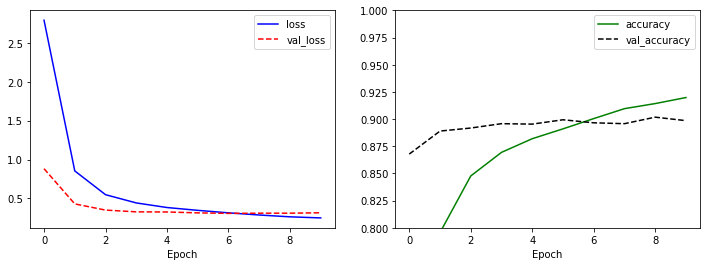

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.8, 1)
plt.legend()

plt.show()

## 라벨 텍스트를 알파벳순으로 정렬

In [14]:
## 라벨 텍스트를 알파벳순으로 정렬
unique_sorted_Y = sorted(unique_Y)
print(unique_sorted_Y)

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

## Inception V3 특징 추출기 - 시퀀셜 모델의 분류 라벨 확인

2022-03-08 12:09:49.592364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


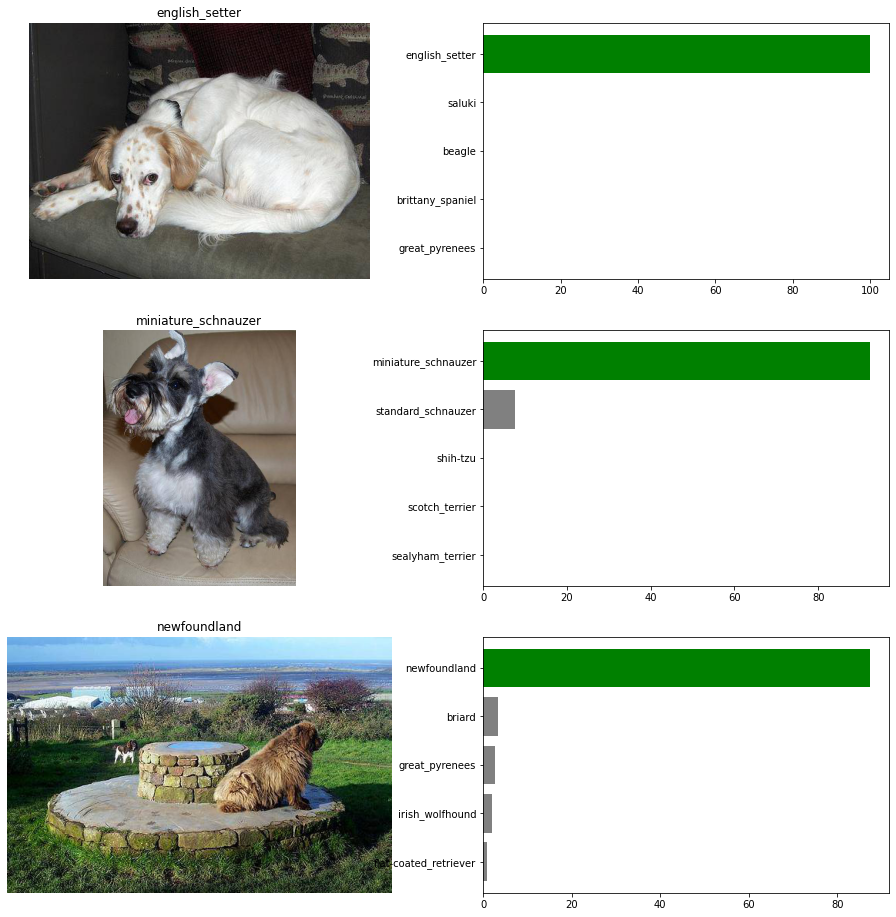

In [15]:
## Inception V3 특징 추출기 - 시퀀셜 모델의 분류 라벨 확인
import random
plt.figure(figsize=(16,16))

for c in range(3):
    image_path = random.choice(valid_generator.filepaths)
    
    # 이미지 표시
    plt.subplot(3,2,c*2+1)
    plt.imshow(plt.imread(image_path))
    real_y = image_path.split('/')[3]
    plt.title(real_y)
    plt.axis('off')
    idx = unique_sorted_Y.index(real_y)
    
    # 예측값 표시
    plt.subplot(3,2,c*2+2)
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(299, 299))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    # Inception V3를 이용한 특징 벡터 추출
    feature_vector = feature_model.predict(img)
    
    # 시퀀셜 모델을 이용한 예측
    prediction = model.predict(feature_vector)[0]
    
    # 가장 높은 확률의 예측값 5개를 뽑음
    top_5_predict = prediction.argsort()[::-1][:5]
    labels = [unique_sorted_Y[index] for index in top_5_predict]
    color = ['gray'] * 5
    if idx in top_5_predict:
        color[top_5_predict.tolist().index(idx)] = 'green'
    color = color[::-1]
    plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color=color)
    plt.yticks(range(5), labels[::-1])

## submission.csv 파일의 내용 확인

In [20]:
# submission.csv 파일의 내용 확인
import pandas as pd
submission = pd.read_csv('./content/sample_submission.csv')
print(submission.head())
print()
print(submission.info())

                                 id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e       0.008333      0.008333   
1  00102ee9d8eb90812350685311fe5890       0.008333      0.008333   
2  0012a730dfa437f5f3613fb75efcd4ce       0.008333      0.008333   
3  001510bc8570bbeee98c8d80c8a95ec1       0.008333      0.008333   
4  001a5f3114548acdefa3d4da05474c2e       0.008333      0.008333   

   african_hunting_dog  airedale  american_staffordshire_terrier  appenzeller  \
0             0.008333  0.008333                        0.008333     0.008333   
1             0.008333  0.008333                        0.008333     0.008333   
2             0.008333  0.008333                        0.008333     0.008333   
3             0.008333  0.008333                        0.008333     0.008333   
4             0.008333  0.008333                        0.008333     0.008333   

   australian_terrier   basenji    basset  ...  toy_poodle  toy_terrier  \
0            0.008333  0.0083

## ImageDataGenerator가 처리할 수 있는 하위 디렉토리 구조로 데이터 복사

In [17]:
## ImageDataGenerator가 처리할 수 있는 하위 디렉토리 구조로 데이터 복사
import os
import shutil

os.mkdir('./content/test_sub/')
os.mkdir('./content/test_sub/unknown/')

for i in range(len(submission)):
    shutil.copy('./content/test/' + submission.loc[i]['id'] + '.jpg', './content/test_sub/unknown/')

# ImageDataGenerator를 이용한 테스트 데이터 불러오기

In [19]:
# ImageDataGenerator를 이용한 테스트 데이터 불러오기
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_directory(directory="./content/test_sub/",
                                                batch_size=1, 
                                                seed=42, 
                                                shuffle=False,
                                                target_size=(299,299))

Found 10357 images belonging to 1 classes.


# 테스트 데이터를 특징 벡터로 변환

In [21]:
# 테스트 데이터를 특징 벡터로 변환
test_features = []

for idx in range(test_generator.n):
    if idx % 100 == 0:
        print(idx)
        
    x, _ = test_generator.next()
    feature = feature_model.predict(x)
    test_features.extend(feature)
    
test_features = np.array(test_features)
print(test_features)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
[[0.18951777 0.7445639  0.16013137 ... 0.37743604 0.08141716 0.22768916]
 [0.06024192 0.9475714  0.36792776 ... 0.4035983  0.8387355  0.352528  ]
 [0.4071687  0.26053935 0.22996835 ... 0.35431978 0.19580244 0.01243906]
 ...
 [0.23371667 0.39877337 0.0529781  ... 0.60544395 0.8201174  0.31311792]
 [0.02645235 0.03323403 0.20861542 ... 0.4072214  0.04707745 0.26029938]
 [0.08439292 0.07781214 0.12429784 ... 0.5256832  1.1622142  0.08559409]]


# 특징 벡터로 테스트 데이터의 정답 예측

In [22]:
# 특징 벡터로 테스트 데이터의 정답 예측
test_Y = model.predict(test_features, verbose=1)

324/324 [==============================] - 1s 2ms/step


## Inception V3 특징 추출기 - 시퀀셜 모델의 테스트 데이터 분류 라벨 확인

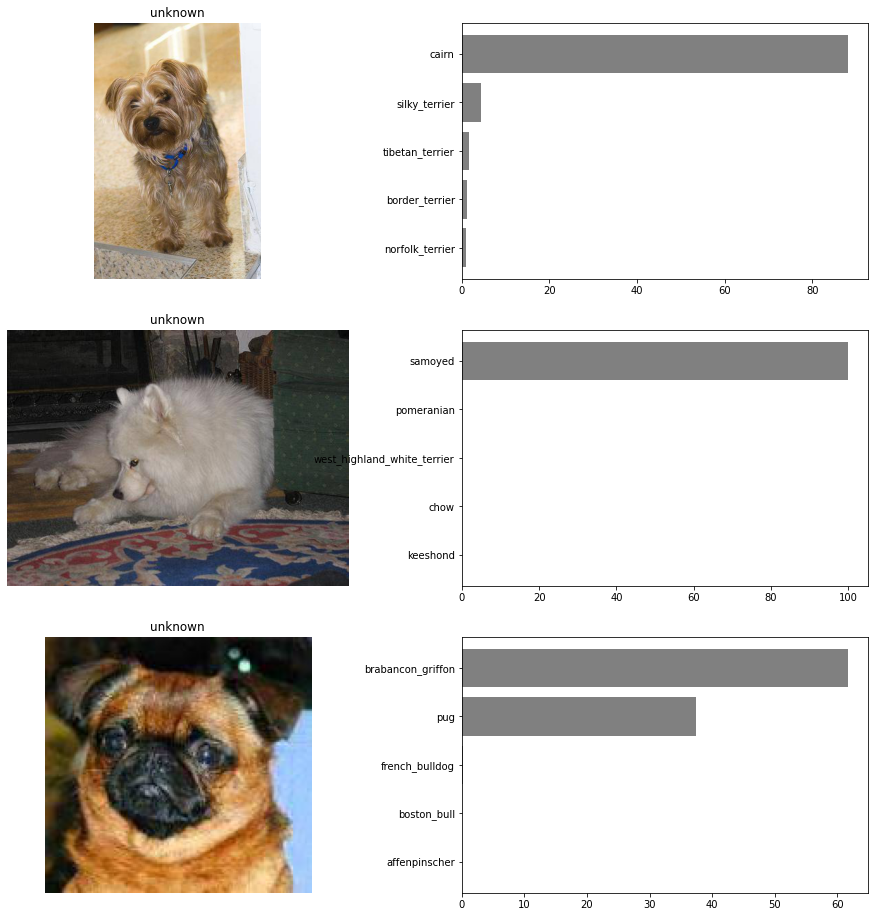

In [25]:
## Inception V3 특징 추출기 - 시퀀셜 모델의 테스트 데이터 분류 라벨 확인
import random
plt.figure(figsize=(16,16))

for c in range(3):
    image_path = random.choice(test_generator.filepaths)
    
    # 이미지 표시
    plt.subplot(3,2,c*2+1)
    plt.imshow(plt.imread(image_path))
    real_y = image_path.split('/')[3]
    plt.title(real_y)
    plt.axis('off')
    
    # 예측값 표시
    plt.subplot(3,2,c*2+2)
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(299, 299))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    # Inception V3를 이용한 특징 벡터 추출
    feature_vector = feature_model.predict(img)
    
    # 시퀀셜 모델을 이용한 예측
    prediction = model.predict(feature_vector)[0]
    
    # 가장 높은 확률의 예측값 5개를 뽑음
    top_5_predict = prediction.argsort()[::-1][:5]
    
    labels = [unique_sorted_Y[index] for index in top_5_predict]
    color = ['gray'] * 5
    plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color=color)
    plt.yticks(range(5), labels[::-1])

## submission 데이터프레임에 예측값 저장

In [26]:
## submission 데이터프레임에 예측값 저장
for i in range(len(test_Y)):
    for j in range(len(test_Y[i])):
        breed_column = unique_sorted_Y[j]
        submission.loc[i, breed_column] = test_Y[i, j]
        
print(submission.head())

                                 id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e   1.278860e-05  5.373225e-07   
1  00102ee9d8eb90812350685311fe5890   2.940733e-07  7.997657e-08   
2  0012a730dfa437f5f3613fb75efcd4ce   1.891889e-07  1.484211e-03   
3  001510bc8570bbeee98c8d80c8a95ec1   6.016376e-06  5.865913e-09   
4  001a5f3114548acdefa3d4da05474c2e   8.456235e-03  7.830115e-06   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         1.810791e-07  6.957202e-08                    5.084914e-07   
1         1.985178e-08  2.502349e-07                    1.850525e-06   
2         1.439870e-05  1.949536e-05                    6.154086e-07   
3         7.748493e-09  3.283394e-07                    1.233283e-06   
4         9.734553e-08  9.627183e-07                    1.957596e-06   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  4.350724e-07        6.692846e-08  1.648824e-07  2.075110e-08  ...   
1  4.747194e-0

In [27]:
print(submission.iloc[:5, :5])

                                 id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e   1.278860e-05  5.373225e-07   
1  00102ee9d8eb90812350685311fe5890   2.940733e-07  7.997657e-08   
2  0012a730dfa437f5f3613fb75efcd4ce   1.891889e-07  1.484211e-03   
3  001510bc8570bbeee98c8d80c8a95ec1   6.016376e-06  5.865913e-09   
4  001a5f3114548acdefa3d4da05474c2e   8.456235e-03  7.830115e-06   

   african_hunting_dog      airedale  
0         1.810791e-07  6.957202e-08  
1         1.985178e-08  2.502349e-07  
2         1.439870e-05  1.949536e-05  
3         7.748493e-09  3.283394e-07  
4         9.734553e-08  9.627183e-07  


In [28]:
submission.to_csv('dogbreed_submission_inceptionV3_epoch10_299.csv', index=False)